# Federated Learning Experiment Analysis

This notebook provides comprehensive visualization and analysis of federated learning experiments.

## Features:
1. **Training Progress**: Global and per-client accuracy/loss trends
2. **Per-Class Performance**: Class-wise accuracy for each client
3. **Gradient Analysis**: Gradient norms and variance across rounds
4. **Convergence Analysis**: Client convergence patterns
5. **Communication Analysis**: Network propagation metrics (for decentralized mode)


## 1. Setup and Configuration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import warnings
warnings.filterwarnings('ignore')

# Set style for publication-ready plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 11

print("Libraries loaded successfully!")

Libraries loaded successfully!


In [2]:
# Configuration: Set the path to your experiment logs
# Automatically find the most recent experiment
logs_base = Path('./logs')

# Get all experiment directories
def get_latest_experiment(base_path, experiment_type=None):
    """Find the most recent experiment directory."""
    if not base_path.exists():
        print(f"Logs directory not found: {base_path}")
        return None
    
    experiments = []
    for exp_dir in base_path.iterdir():
        if exp_dir.is_dir():
            if experiment_type and experiment_type not in exp_dir.name:
                continue
            # Find all timestamp subdirectories
            for timestamp_dir in exp_dir.iterdir():
                if timestamp_dir.is_dir():
                    experiments.append(timestamp_dir)
    
    if not experiments:
        print("No experiments found!")
        return None
    
    # Sort by modification time and get the latest
    latest = max(experiments, key=lambda p: p.stat().st_mtime)
    return latest

# Find latest experiment (change experiment_type to filter)
experiment_dir = get_latest_experiment(logs_base, experiment_type=None)

if experiment_dir:
    print(f"Loading experiment from: {experiment_dir}")
    plots_dir = experiment_dir / "plots"
    plots_dir.mkdir(exist_ok=True)
    print(f"Plots will be saved to: {plots_dir}")
else:
    print("No experiment found. Please run training first!")

Loading experiment from: logs\centralized_fedavg\2026-02-04_13-24-00
Plots will be saved to: logs\centralized_fedavg\2026-02-04_13-24-00\plots


In [3]:
# Load all CSV files
if experiment_dir:
    client_metrics_file = experiment_dir / "client_metrics.csv"
    global_metrics_file = experiment_dir / "global_metrics.csv"
    gradient_tracking_file = experiment_dir / "gradient_tracking.csv"
    communication_logs_file = experiment_dir / "communication_logs.csv"
    round_summary_file = experiment_dir / "round_summary.csv"
    config_file = experiment_dir / "config.json"
    
    # Load config
    if config_file.exists():
        with open(config_file, 'r') as f:
            config = json.load(f)
        print(f"Experiment Type: {config.get('type', 'unknown')}")
        print(f"Model: {config.get('model', 'unknown')}")
        print(f"Dataset: {config.get('dataset', 'unknown')}")
        print(f"Num Clients: {config.get('num_clients', 'unknown')}")
        print(f"Rounds: {config.get('rounds', 'unknown')}")
        print(f"Local Epochs: {config.get('epochs', 'unknown')}")
    
    # Load metrics
    df_client = pd.read_csv(client_metrics_file) if client_metrics_file.exists() else None
    df_global = pd.read_csv(global_metrics_file) if global_metrics_file.exists() else None
    df_gradient = pd.read_csv(gradient_tracking_file) if gradient_tracking_file.exists() else None
    df_comm = pd.read_csv(communication_logs_file) if communication_logs_file.exists() else None
    df_summary = pd.read_csv(round_summary_file) if round_summary_file.exists() else None
    
    print(f"\nData loaded:")
    print(f"  Client metrics: {len(df_client) if df_client is not None else 0} entries")
    print(f"  Global metrics: {len(df_global) if df_global is not None else 0} entries")
    print(f"  Gradient tracking: {len(df_gradient) if df_gradient is not None else 0} entries")
    print(f"  Communication logs: {len(df_comm) if df_comm is not None else 0} entries")
    print(f"  Round summaries: {len(df_summary) if df_summary is not None else 0} entries")

Experiment Type: centralized
Model: simple_cnn
Dataset: cifar10
Num Clients: 10
Rounds: 10
Local Epochs: 5

Data loaded:
  Client metrics: 2000 entries
  Global metrics: 20 entries
  Gradient tracking: 500 entries
  Communication logs: 0 entries
  Round summaries: 10 entries


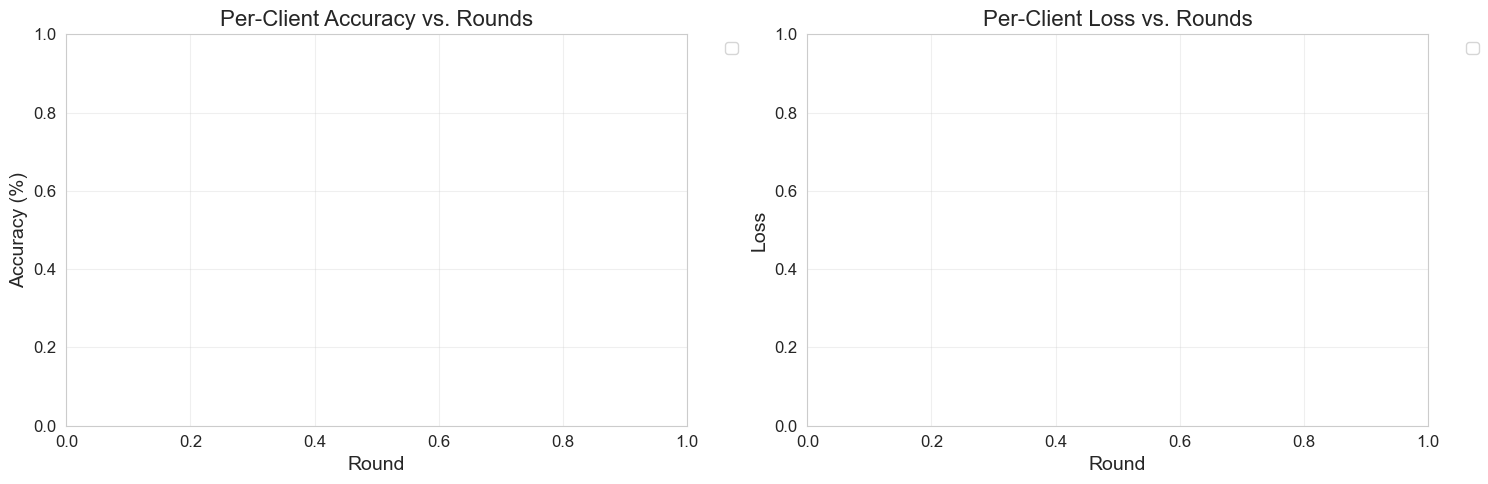

In [4]:
if df_client is not None and len(df_client) > 0:
    # Filter for accuracy and loss metrics (exclude class-specific)
    df_acc = df_client[(df_client['metric_type'] == 'accuracy') & (df_client['class_id'] == '')]
    df_loss = df_client[(df_client['metric_type'] == 'loss') & (df_client['class_id'] == '')]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Per-client accuracy
    for client_id in df_acc['client_id'].unique():
        client_data = df_acc[df_acc['client_id'] == client_id]
        # Get final epoch of each round
        final_epoch_data = client_data.groupby('round').last().reset_index()
        ax1.plot(final_epoch_data['round'], final_epoch_data['value'], 
                marker='o', label=f'Client {client_id}', alpha=0.7)
    
    ax1.set_xlabel('Round')
    ax1.set_ylabel('Accuracy (%)')
    ax1.set_title('Per-Client Accuracy vs. Rounds')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.grid(True, alpha=0.3)
    
    # Per-client loss
    for client_id in df_loss['client_id'].unique():
        client_data = df_loss[df_loss['client_id'] == client_id]
        # Get final epoch of each round
        final_epoch_data = client_data.groupby('round').last().reset_index()
        ax2.plot(final_epoch_data['round'], final_epoch_data['value'], 
                marker='o', label=f'Client {client_id}', alpha=0.7)
    
    ax2.set_xlabel('Round')
    ax2.set_ylabel('Loss')
    ax2.set_title('Per-Client Loss vs. Rounds')
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(plots_dir / 'per_client_progress.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("No client metrics available")

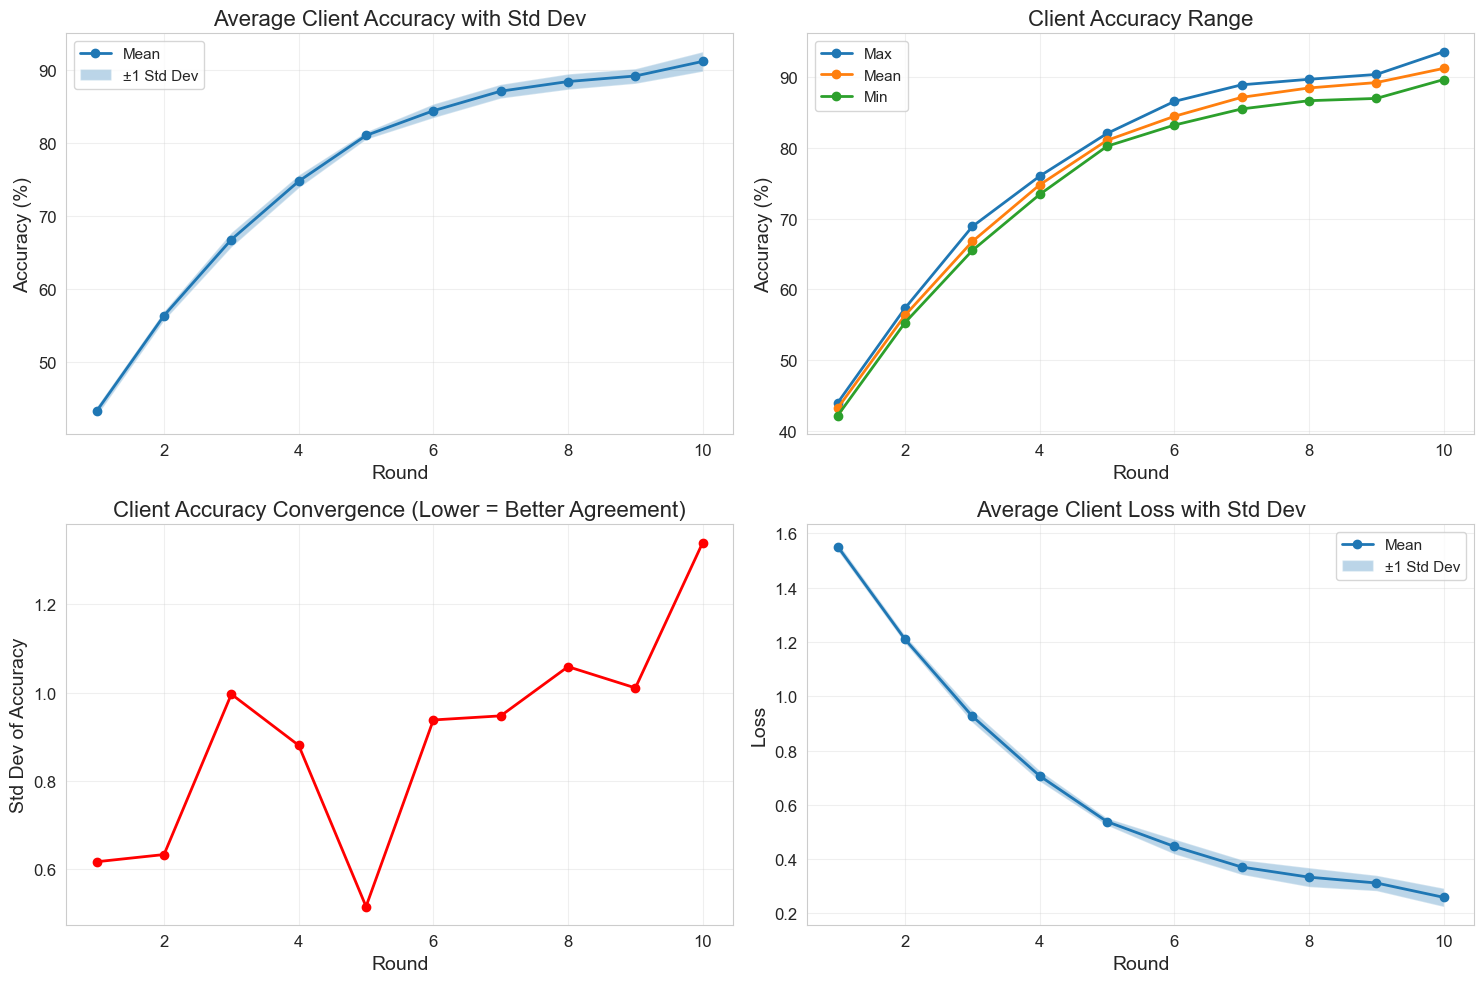

In [5]:
if df_summary is not None and len(df_summary) > 0:
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # Average accuracy with std
    ax1.plot(df_summary['round'], df_summary['avg_accuracy'], marker='o', linewidth=2, label='Mean')
    ax1.fill_between(df_summary['round'], 
                     df_summary['avg_accuracy'] - df_summary['std_accuracy'],
                     df_summary['avg_accuracy'] + df_summary['std_accuracy'],
                     alpha=0.3, label='±1 Std Dev')
    ax1.set_xlabel('Round')
    ax1.set_ylabel('Accuracy (%)')
    ax1.set_title('Average Client Accuracy with Std Dev')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Min/Max accuracy
    ax2.plot(df_summary['round'], df_summary['max_accuracy'], marker='o', label='Max', linewidth=2)
    ax2.plot(df_summary['round'], df_summary['avg_accuracy'], marker='o', label='Mean', linewidth=2)
    ax2.plot(df_summary['round'], df_summary['min_accuracy'], marker='o', label='Min', linewidth=2)
    ax2.set_xlabel('Round')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Client Accuracy Range')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Standard deviation convergence (client agreement)
    ax3.plot(df_summary['round'], df_summary['std_accuracy'], marker='o', linewidth=2, color='red')
    ax3.set_xlabel('Round')
    ax3.set_ylabel('Std Dev of Accuracy')
    ax3.set_title('Client Accuracy Convergence (Lower = Better Agreement)')
    ax3.grid(True, alpha=0.3)
    
    # Average loss with std
    ax4.plot(df_summary['round'], df_summary['avg_loss'], marker='o', linewidth=2, label='Mean')
    ax4.fill_between(df_summary['round'], 
                     df_summary['avg_loss'] - df_summary['std_loss'],
                     df_summary['avg_loss'] + df_summary['std_loss'],
                     alpha=0.3, label='±1 Std Dev')
    ax4.set_xlabel('Round')
    ax4.set_ylabel('Loss')
    ax4.set_title('Average Client Loss with Std Dev')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(plots_dir / 'convergence_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("No round summary data available")

In [6]:
print("="*60)
print("EXPERIMENT SUMMARY")
print("="*60)

if df_summary is not None and len(df_summary) > 0:
    final_round = df_summary.iloc[-1]
    print(f"\nFinal Round Statistics:")
    print(f"  Average Accuracy: {final_round['avg_accuracy']:.2f}% (±{final_round['std_accuracy']:.2f}%)")
    print(f"  Min Accuracy: {final_round['min_accuracy']:.2f}%")
    print(f"  Max Accuracy: {final_round['max_accuracy']:.2f}%")
    print(f"  Average Loss: {final_round['avg_loss']:.4f} (±{final_round['std_loss']:.4f})")
    
    if final_round['gradient_norm_mean'] != '':
        print(f"  Gradient Norm: {final_round['gradient_norm_mean']:.4f} (±{final_round['gradient_norm_std']:.4f})")
    
    # Improvement metrics
    if len(df_summary) > 1:
        first_round = df_summary.iloc[0]
        acc_improvement = final_round['avg_accuracy'] - first_round['avg_accuracy']
        loss_improvement = first_round['avg_loss'] - final_round['avg_loss']
        std_improvement = first_round['std_accuracy'] - final_round['std_accuracy']
        
        print(f"\nImprovement from Round 1 to Final:")
        print(f"  Accuracy: {'+' if acc_improvement >= 0 else ''}{acc_improvement:.2f}%")
        print(f"  Loss: {'+' if loss_improvement >= 0 else ''}{loss_improvement:.4f}")
        print(f"  Std Dev: {'+' if std_improvement >= 0 else ''}{std_improvement:.2f}% (lower is better)")

if df_comm is not None and len(df_comm) > 0:
    print(f"\nCommunication Statistics:")
    print(f"  Total Communications: {len(df_comm)}")
    print(f"  Average per Round: {len(df_comm) / df_comm['round'].nunique():.1f}")
    print(f"  Average Communication Time: {df_comm['communication_time'].mean():.4f}s")

print("\n" + "="*60)
print(f"All plots saved to: {plots_dir}")
print("="*60)

EXPERIMENT SUMMARY

Final Round Statistics:
  Average Accuracy: 91.18% (±1.34%)
  Min Accuracy: 89.60%
  Max Accuracy: 93.54%
  Average Loss: 0.2592 (±0.0338)
  Gradient Norm: 4.1176 (±0.3022)

Improvement from Round 1 to Final:
  Accuracy: +47.91%
  Loss: +1.2919
  Std Dev: -0.72% (lower is better)

All plots saved to: logs\centralized_fedavg\2026-02-04_13-24-00\plots


## 9. Summary Statistics

In [7]:
if df_comm is not None and len(df_comm) > 0:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Communication events per round
    comm_per_round = df_comm.groupby('round').size()
    ax1.bar(comm_per_round.index, comm_per_round.values, alpha=0.7)
    ax1.set_xlabel('Round')
    ax1.set_ylabel('Number of Communications')
    ax1.set_title('Communication Events per Round')
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Average communication time per round
    avg_comm_time = df_comm.groupby('round')['communication_time'].mean()
    ax2.plot(avg_comm_time.index, avg_comm_time.values, marker='o', linewidth=2)
    ax2.set_xlabel('Round')
    ax2.set_ylabel('Average Communication Time (s)')
    ax2.set_title('Average Communication Time per Round')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(plots_dir / 'communication_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Communication matrix (heatmap)
    if len(df_comm) > 0:
        # Create communication matrix
        clients = sorted(list(set(df_comm['source_client'].unique()) | set(df_comm['target_client'].unique())))
        comm_matrix = np.zeros((len(clients), len(clients)))
        
        for _, row in df_comm.iterrows():
            src = int(row['source_client'])
            tgt = int(row['target_client'])
            comm_matrix[src, tgt] += 1
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(comm_matrix, annot=True, fmt='.0f', cmap='YlOrRd', 
                   xticklabels=clients, yticklabels=clients, cbar_kws={'label': 'Communication Count'})
        plt.xlabel('Target Client')
        plt.ylabel('Source Client')
        plt.title('Total Communication Matrix (All Rounds)')
        plt.tight_layout()
        plt.savefig(plots_dir / 'communication_matrix.png', dpi=300, bbox_inches='tight')
        plt.show()
else:
    print("No communication logs available (might be centralized mode)")

No communication logs available (might be centralized mode)


## 8. Communication Analysis (Decentralized Mode)

## 7. Convergence Analysis

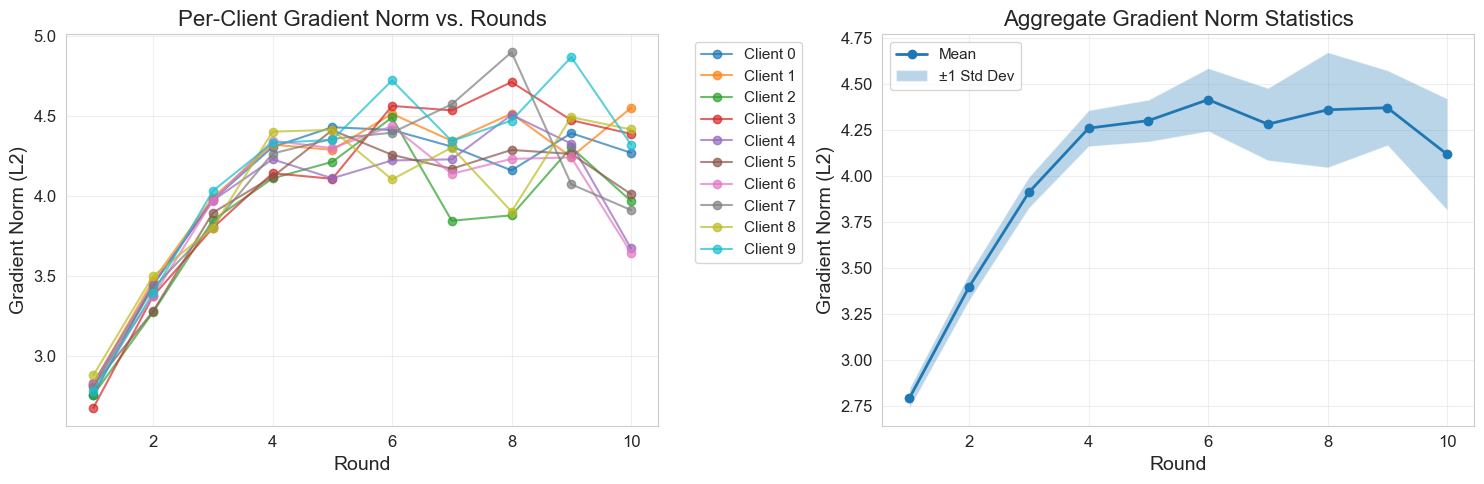

In [8]:
if df_gradient is not None and len(df_gradient) > 0:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Per-client gradient norms
    for client_id in df_gradient['client_id'].unique():
        client_data = df_gradient[df_gradient['client_id'] == client_id]
        # Get final epoch of each round
        final_epoch_data = client_data.groupby('round').last().reset_index()
        ax1.plot(final_epoch_data['round'], final_epoch_data['gradient_norm'], 
                marker='o', label=f'Client {client_id}', alpha=0.7)
    
    ax1.set_xlabel('Round')
    ax1.set_ylabel('Gradient Norm (L2)')
    ax1.set_title('Per-Client Gradient Norm vs. Rounds')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.grid(True, alpha=0.3)
    
    # Aggregate gradient statistics
    if df_summary is not None and len(df_summary) > 0:
        ax2.plot(df_summary['round'], df_summary['gradient_norm_mean'], 
                marker='o', label='Mean', linewidth=2)
        ax2.fill_between(df_summary['round'], 
                         df_summary['gradient_norm_mean'] - df_summary['gradient_norm_std'],
                         df_summary['gradient_norm_mean'] + df_summary['gradient_norm_std'],
                         alpha=0.3, label='±1 Std Dev')
        ax2.set_xlabel('Round')
        ax2.set_ylabel('Gradient Norm (L2)')
        ax2.set_title('Aggregate Gradient Norm Statistics')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(plots_dir / 'gradient_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("No gradient tracking data available")

## 6. Gradient Analysis

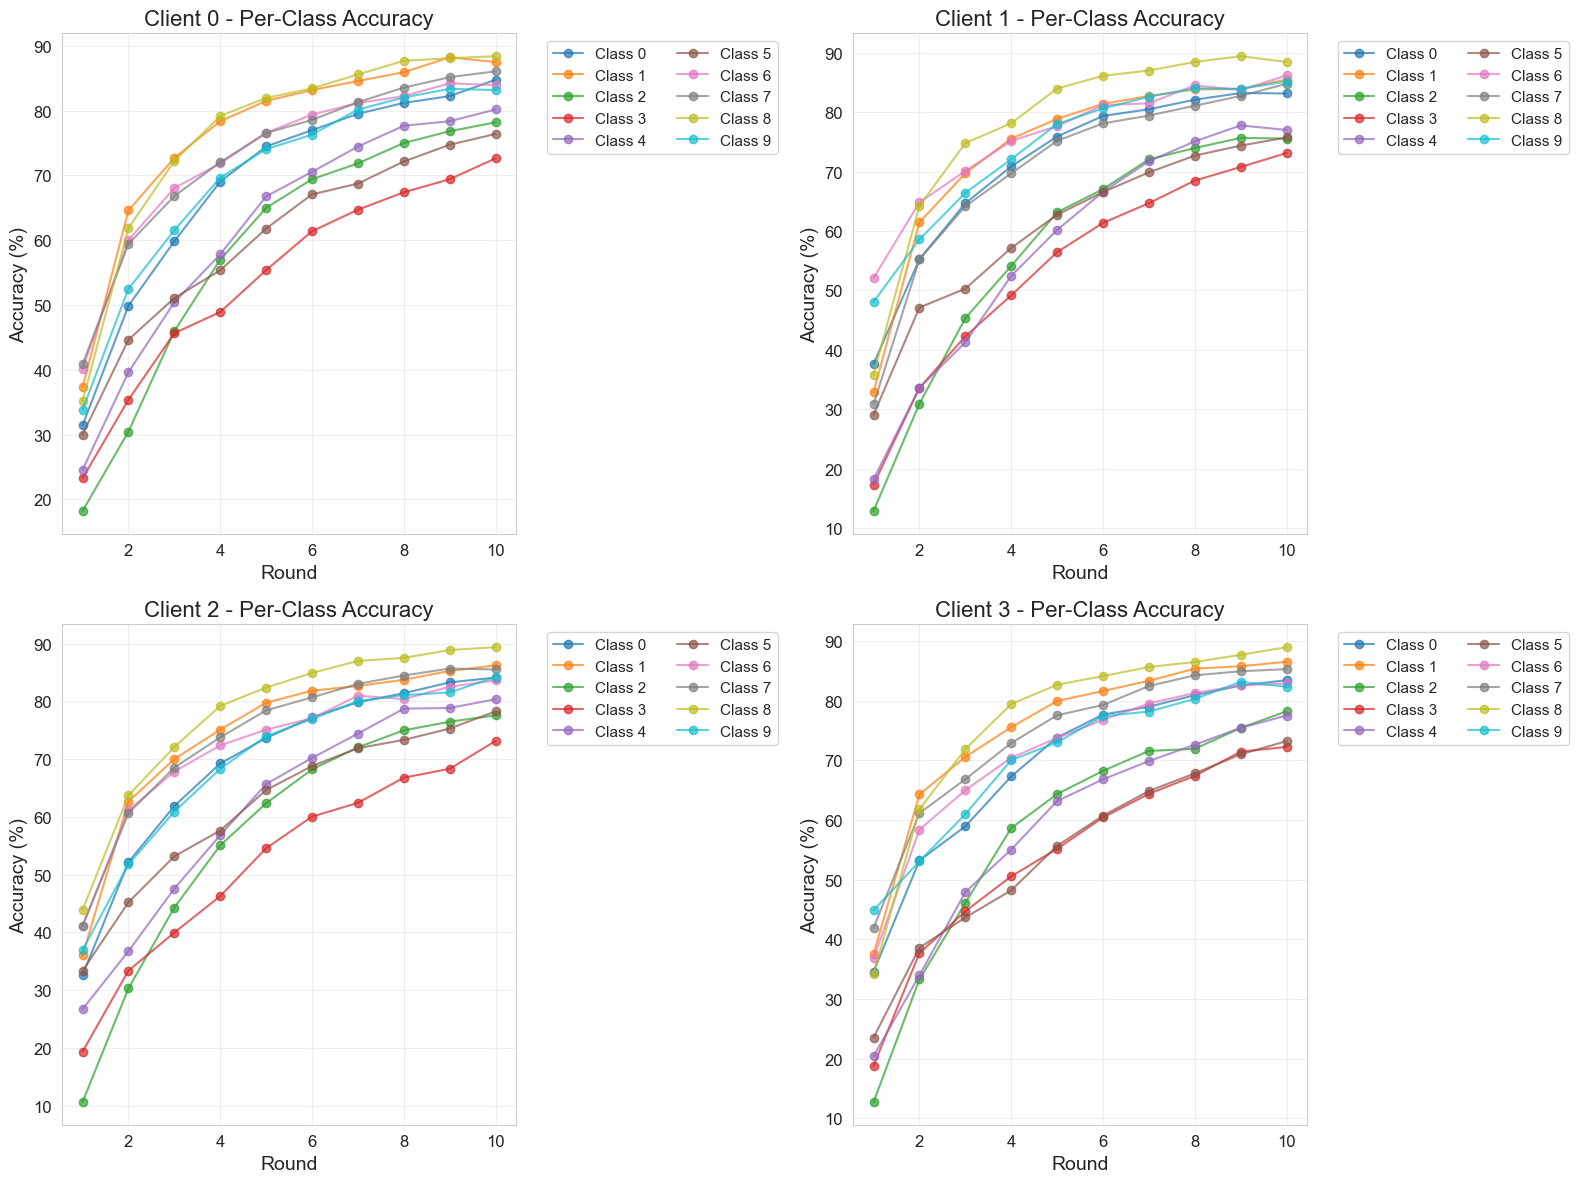

In [9]:
if df_client is not None and len(df_client) > 0:
    # Filter for class-specific accuracy
    df_class = df_client[(df_client['metric_type'] == 'class_accuracy') & (df_client['class_id'] != '')]
    
    if len(df_class) > 0:
        # Get unique clients and classes
        clients = sorted(df_class['client_id'].unique())
        classes = sorted(df_class['class_id'].unique())
        
        # Create subplots for each client (show first 4 clients to avoid clutter)
        num_clients_to_show = min(4, len(clients))
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        axes = axes.flatten()
        
        for idx, client_id in enumerate(clients[:num_clients_to_show]):
            ax = axes[idx]
            client_data = df_class[df_class['client_id'] == client_id]
            
            for class_id in classes:
                class_data = client_data[client_data['class_id'] == class_id]
                if len(class_data) > 0:
                    ax.plot(class_data['round'], class_data['value'], 
                           marker='o', label=f'Class {int(class_id)}', alpha=0.7)
            
            ax.set_xlabel('Round')
            ax.set_ylabel('Accuracy (%)')
            ax.set_title(f'Client {client_id} - Per-Class Accuracy')
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)
            ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(plots_dir / 'per_class_performance.png', dpi=300, bbox_inches='tight')
        plt.show()
    else:
        print("No per-class metrics available")
else:
    print("No client metrics available")

## 5. Per-Class Performance Analysis

## 4. Per-Client Training Progress

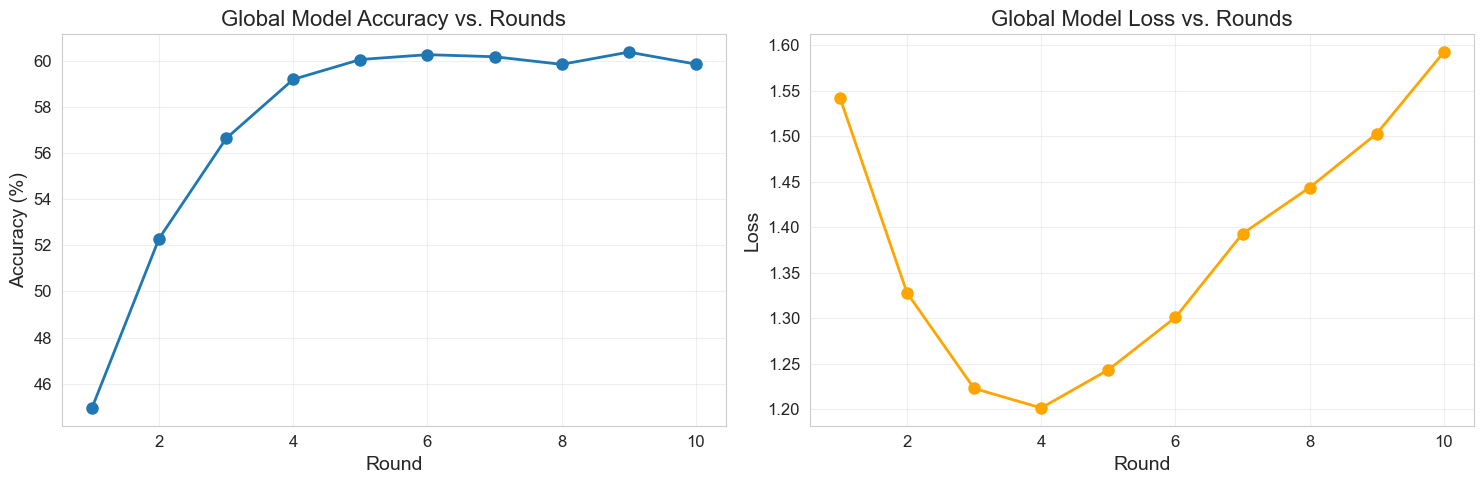

In [10]:
if df_global is not None and len(df_global) > 0:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Global Accuracy
    global_acc = df_global[df_global['metric_type'] == 'global_accuracy']
    ax1.plot(global_acc['round'], global_acc['value'], marker='o', linewidth=2, markersize=8)
    ax1.set_xlabel('Round')
    ax1.set_ylabel('Accuracy (%)')
    ax1.set_title('Global Model Accuracy vs. Rounds')
    ax1.grid(True, alpha=0.3)
    
    # Global Loss
    global_loss = df_global[df_global['metric_type'] == 'global_loss']
    ax2.plot(global_loss['round'], global_loss['value'], marker='o', linewidth=2, markersize=8, color='orange')
    ax2.set_xlabel('Round')
    ax2.set_ylabel('Loss')
    ax2.set_title('Global Model Loss vs. Rounds')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(plots_dir / 'global_performance.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("No global metrics available (might be decentralized mode)")

## 3. Global Model Performance (Centralized Mode)

## 2. Load Experiment Data

## Per-Class Performance Analysis

In [ ]:
# Load per-class metrics if available
per_class_file = experiment_dir / 'per_class_metrics.csv'
if per_class_file.exists():
    df_per_class = pd.read_csv(per_class_file)
    print(f"Loaded {len(df_per_class)} per-class metric records")
    
    # Show per-class precision, recall, F1 heatmap
    if len(df_per_class) > 0:
        # Get final round data
        final_round = df_per_class['round'].max()
        final_class_data = df_per_class[df_per_class['round'] == final_round]
        
        # Create pivot tables for each metric
        precision_pivot = final_class_data.pivot_table(
            values='precision', index='client_id', columns='class_id', aggfunc='mean'
        )
        recall_pivot = final_class_data.pivot_table(
            values='recall', index='client_id', columns='class_id', aggfunc='mean'
        )
        f1_pivot = final_class_data.pivot_table(
            values='f1_score', index='client_id', columns='class_id', aggfunc='mean'
        )
        
        # Plot heatmaps
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        
        sns.heatmap(precision_pivot, annot=True, fmt='.2f', cmap='YlGnBu', 
                    ax=axes[0], cbar_kws={'label': 'Precision'})
        axes[0].set_title(f'Precision per Class (Round {final_round})')
        axes[0].set_xlabel('Class ID')
        axes[0].set_ylabel('Client ID')
        
        sns.heatmap(recall_pivot, annot=True, fmt='.2f', cmap='YlOrRd', 
                    ax=axes[1], cbar_kws={'label': 'Recall'})
        axes[1].set_title(f'Recall per Class (Round {final_round})')
        axes[1].set_xlabel('Class ID')
        axes[1].set_ylabel('Client ID')
        
        sns.heatmap(f1_pivot, annot=True, fmt='.2f', cmap='Greens', 
                    ax=axes[2], cbar_kws={'label': 'F1 Score'})
        axes[2].set_title(f'F1 Score per Class (Round {final_round})')
        axes[2].set_xlabel('Class ID')
        axes[2].set_ylabel('Client ID')
        
        plt.tight_layout()
        plt.savefig(plots_dir / 'per_class_heatmaps.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"\nAverage metrics across all classes:")
        print(f"  Precision: {df_per_class['precision'].mean():.4f}")
        print(f"  Recall: {df_per_class['recall'].mean():.4f}")
        print(f"  F1 Score: {df_per_class['f1_score'].mean():.4f}")
else:
    print("Per-class metrics file not found")

## Gradient Analysis

In [ ]:
# Load gradient metrics if available
gradient_file = experiment_dir / 'gradient_metrics.csv'
layer_gradient_file = experiment_dir / 'layer_gradient_metrics.csv'

if gradient_file.exists():
    df_grad = pd.read_csv(gradient_file)
    print(f"Loaded {len(df_grad)} gradient metric records")
    
    # Plot gradient norm evolution
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. L2 norm over rounds (all clients)
    for client_id in df_grad['client_id'].unique()[:10]:  # Show first 10 clients
        client_data = df_grad[df_grad['client_id'] == client_id]
        axes[0, 0].plot(client_data['round'], client_data['l2_norm'], 
                       alpha=0.7, label=f'Client {client_id}')
    axes[0, 0].set_xlabel('Round')
    axes[0, 0].set_ylabel('L2 Gradient Norm')
    axes[0, 0].set_title('L2 Gradient Norm Evolution')
    axes[0, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Linf norm over rounds
    for client_id in df_grad['client_id'].unique()[:10]:
        client_data = df_grad[df_grad['client_id'] == client_id]
        axes[0, 1].plot(client_data['round'], client_data['linf_norm'], 
                       alpha=0.7, label=f'Client {client_id}')
    axes[0, 1].set_xlabel('Round')
    axes[0, 1].set_ylabel('L∞ Gradient Norm')
    axes[0, 1].set_title('L∞ Gradient Norm Evolution')
    axes[0, 1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Average gradient norm per round
    avg_grad_per_round = df_grad.groupby('round')['l2_norm'].agg(['mean', 'std'])
    axes[1, 0].plot(avg_grad_per_round.index, avg_grad_per_round['mean'], 
                   marker='o', linewidth=2, label='Mean')
    axes[1, 0].fill_between(avg_grad_per_round.index,
                            avg_grad_per_round['mean'] - avg_grad_per_round['std'],
                            avg_grad_per_round['mean'] + avg_grad_per_round['std'],
                            alpha=0.3, label='±1 std')
    axes[1, 0].set_xlabel('Round')
    axes[1, 0].set_ylabel('Average L2 Gradient Norm')
    axes[1, 0].set_title('Average Gradient Norm (All Clients)')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Gradient norm distribution (final round)
    final_round_grads = df_grad[df_grad['round'] == df_grad['round'].max()]
    axes[1, 1].hist(final_round_grads['l2_norm'], bins=20, alpha=0.7, 
                   color='steelblue', edgecolor='black')
    axes[1, 1].axvline(final_round_grads['l2_norm'].mean(), 
                      color='red', linestyle='--', linewidth=2, label='Mean')
    axes[1, 1].set_xlabel('L2 Gradient Norm')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_title(f'Gradient Norm Distribution (Round {df_grad["round"].max()})')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig(plots_dir / 'gradient_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\nGradient Statistics:")
    print(f"  Average L2 norm: {df_grad['l2_norm'].mean():.6f}")
    print(f"  Average L∞ norm: {df_grad['linf_norm'].mean():.6f}")
    print(f"  Max gradient norm: {df_grad['l2_norm'].max():.6f}")
    print(f"  Min gradient norm: {df_grad['l2_norm'].min():.6f}")
else:
    print("Gradient metrics file not found")

# Load layer-wise gradient metrics if available
if layer_gradient_file.exists():
    df_layer_grad = pd.read_csv(layer_gradient_file)
    print(f"\nLoaded {len(df_layer_grad)} layer gradient records")
    
    # Plot layer-wise gradient norms (final round)
    final_round = df_layer_grad['round'].max()
    final_layer_data = df_layer_grad[df_layer_grad['round'] == final_round]
    
    # Group by layer
    layer_stats = final_layer_data.groupby('layer_name')['l2_norm'].agg(['mean', 'std'])
    layer_stats = layer_stats.sort_values('mean', ascending=False)
    
    fig, ax = plt.subplots(figsize=(14, 6))
    x_pos = np.arange(len(layer_stats))
    ax.bar(x_pos, layer_stats['mean'], yerr=layer_stats['std'], 
           alpha=0.7, color='coral', capsize=5)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(layer_stats.index, rotation=45, ha='right')
    ax.set_xlabel('Layer Name')
    ax.set_ylabel('L2 Gradient Norm')
    ax.set_title(f'Layer-wise Gradient Norms (Round {final_round})')
    ax.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.savefig(plots_dir / 'layer_gradient_norms.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("Layer gradient metrics file not found")

## Convergence and Straggler Analysis

In [ ]:
# Load convergence metrics if available
convergence_file = experiment_dir / 'convergence_metrics.csv'
if convergence_file.exists():
    df_conv = pd.read_csv(convergence_file)
    print(f"Loaded {len(df_conv)} convergence metric records")
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Straggler identification over rounds
    straggler_counts = df_conv.groupby('round')['is_straggler'].sum()
    axes[0, 0].plot(straggler_counts.index, straggler_counts.values, 
                   marker='o', linewidth=2, color='red')
    axes[0, 0].set_xlabel('Round')
    axes[0, 0].set_ylabel('Number of Stragglers')
    axes[0, 0].set_title('Stragglers per Round')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Convergence rate distribution
    axes[0, 1].hist(df_conv['convergence_rate'], bins=30, alpha=0.7, 
                   color='green', edgecolor='black')
    axes[0, 1].axvline(df_conv['convergence_rate'].mean(), 
                      color='red', linestyle='--', linewidth=2, label='Mean')
    axes[0, 1].set_xlabel('Convergence Rate')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].set_title('Convergence Rate Distribution')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3, axis='y')
    
    # 3. Average loss vs convergence rate
    axes[1, 0].scatter(df_conv['convergence_rate'], df_conv['average_loss'], 
                      alpha=0.5, s=50)
    axes[1, 0].set_xlabel('Convergence Rate')
    axes[1, 0].set_ylabel('Average Loss')
    axes[1, 0].set_title('Loss vs Convergence Rate')
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Straggler clients heatmap
    straggler_pivot = df_conv.pivot_table(
        values='is_straggler', index='client_id', columns='round', aggfunc='max'
    )
    sns.heatmap(straggler_pivot, cmap='RdYlGn_r', cbar_kws={'label': 'Is Straggler'}, 
                ax=axes[1, 1])
    axes[1, 1].set_title('Straggler Pattern (Red = Straggler)')
    axes[1, 1].set_xlabel('Round')
    axes[1, 1].set_ylabel('Client ID')
    
    plt.tight_layout()
    plt.savefig(plots_dir / 'convergence_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\nConvergence Statistics:")
    print(f"  Average convergence rate: {df_conv['convergence_rate'].mean():.6f}")
    print(f"  Total stragglers detected: {df_conv['is_straggler'].sum()}")
    print(f"  Percentage of stragglers: {df_conv['is_straggler'].mean() * 100:.2f}%")
else:
    print("Convergence metrics file not found")

## Data Distribution and Heterogeneity

In [ ]:
# Load data distribution metrics if available
data_dist_file = experiment_dir / 'data_distribution.csv'
if data_dist_file.exists():
    df_dist = pd.read_csv(data_dist_file)
    print(f"Loaded {len(df_dist)} data distribution records")
    
    # Parse class distribution JSON
    import json
    df_dist['class_dist_parsed'] = df_dist['class_distribution'].apply(json.loads)
    
    # Get initial distribution (round 0)
    initial_dist = df_dist[df_dist['round'] == 0]
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Heterogeneity scores by client
    heterogeneity_by_client = initial_dist.groupby('client_id')['heterogeneity_score'].mean()
    axes[0, 0].bar(heterogeneity_by_client.index, heterogeneity_by_client.values, 
                   alpha=0.7, color='purple')
    axes[0, 0].set_xlabel('Client ID')
    axes[0, 0].set_ylabel('Heterogeneity Score (KL Divergence)')
    axes[0, 0].set_title('Data Heterogeneity by Client')
    axes[0, 0].grid(True, alpha=0.3, axis='y')
    
    # 2. Total samples per client
    samples_by_client = initial_dist.groupby('client_id')['total_samples'].sum()
    axes[0, 1].bar(samples_by_client.index, samples_by_client.values, 
                   alpha=0.7, color='teal')
    axes[0, 1].set_xlabel('Client ID')
    axes[0, 1].set_ylabel('Total Samples')
    axes[0, 1].set_title('Dataset Size by Client')
    axes[0, 1].grid(True, alpha=0.3, axis='y')
    
    # 3. Class distribution heatmap
    # Extract class distributions into a matrix
    num_clients = len(initial_dist['client_id'].unique())
    class_ids = set()
    for dist_str in initial_dist['class_distribution']:
        dist_dict = json.loads(dist_str)
        class_ids.update(dist_dict.keys())
    class_ids = sorted([int(c) for c in class_ids])
    
    dist_matrix = np.zeros((num_clients, len(class_ids)))
    for idx, row in initial_dist.iterrows():
        client_id = row['client_id']
        dist_dict = json.loads(row['class_distribution'])
        for class_id in class_ids:
            dist_matrix[client_id, class_ids.index(class_id)] = dist_dict.get(str(class_id), 0)
    
    sns.heatmap(dist_matrix, annot=True, fmt='.2f', cmap='YlOrRd', 
                xticklabels=class_ids, yticklabels=range(num_clients),
                ax=axes[1, 0], cbar_kws={'label': 'Proportion'})
    axes[1, 0].set_xlabel('Class ID')
    axes[1, 0].set_ylabel('Client ID')
    axes[1, 0].set_title('Class Distribution Heatmap')
    
    # 4. Heterogeneity score distribution
    axes[1, 1].hist(initial_dist['heterogeneity_score'], bins=20, alpha=0.7, 
                   color='orange', edgecolor='black')
    axes[1, 1].axvline(initial_dist['heterogeneity_score'].mean(), 
                      color='red', linestyle='--', linewidth=2, label='Mean')
    axes[1, 1].set_xlabel('Heterogeneity Score')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_title('Heterogeneity Score Distribution')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig(plots_dir / 'data_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\nData Distribution Statistics:")
    print(f"  Average heterogeneity score: {initial_dist['heterogeneity_score'].mean():.4f}")
    print(f"  Total samples across clients: {initial_dist['total_samples'].sum()}")
    print(f"  Sample imbalance ratio: {initial_dist['total_samples'].max() / initial_dist['total_samples'].min():.2f}x")
else:
    print("Data distribution file not found")

## P2P Propagation Analysis (Decentralized Only)

In [ ]:
# Load propagation metrics if available (P2P only)
propagation_file = experiment_dir / 'propagation_metrics.csv'
if propagation_file.exists():
    df_prop = pd.read_csv(propagation_file)
    print(f"Loaded {len(df_prop)} propagation metric records")
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # 1. Average propagation delay over rounds
    avg_delay_per_round = df_prop.groupby('round')['propagation_delay'].agg(['mean', 'std'])
    axes[0, 0].plot(avg_delay_per_round.index, avg_delay_per_round['mean'], 
                   marker='o', linewidth=2)
    axes[0, 0].fill_between(avg_delay_per_round.index,
                            avg_delay_per_round['mean'] - avg_delay_per_round['std'],
                            avg_delay_per_round['mean'] + avg_delay_per_round['std'],
                            alpha=0.3)
    axes[0, 0].set_xlabel('Round')
    axes[0, 0].set_ylabel('Propagation Delay (ms)')
    axes[0, 0].set_title('Average Propagation Delay')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Hop count distribution
    axes[0, 1].hist(df_prop['hop_count'], bins=range(1, df_prop['hop_count'].max()+2), 
                   alpha=0.7, color='skyblue', edgecolor='black')
    axes[0, 1].set_xlabel('Hop Count')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].set_title('Hop Count Distribution')
    axes[0, 1].grid(True, alpha=0.3, axis='y')
    
    # 3. Inter-cluster vs intra-cluster communication
    inter_cluster_count = df_prop['inter_cluster_communication'].sum()
    intra_cluster_count = len(df_prop) - inter_cluster_count
    axes[0, 2].pie([intra_cluster_count, inter_cluster_count], 
                   labels=['Intra-cluster', 'Inter-cluster'],
                   autopct='%1.1f%%', colors=['lightgreen', 'salmon'])
    axes[0, 2].set_title('Communication Type Distribution')
    
    # 4. Bytes transferred over rounds
    bytes_per_round = df_prop.groupby('round')['bytes_transferred'].sum() / (1024**2)  # Convert to MB
    axes[1, 0].plot(bytes_per_round.index, bytes_per_round.values, 
                   marker='s', linewidth=2, color='orange')
    axes[1, 0].set_xlabel('Round')
    axes[1, 0].set_ylabel('Total Data Transferred (MB)')
    axes[1, 0].set_title('Data Transfer per Round')
    axes[1, 0].grid(True, alpha=0.3)
    
    # 5. Propagation delay vs hop count
    axes[1, 1].scatter(df_prop['hop_count'], df_prop['propagation_delay'], 
                      alpha=0.3, s=30)
    axes[1, 1].set_xlabel('Hop Count')
    axes[1, 1].set_ylabel('Propagation Delay (ms)')
    axes[1, 1].set_title('Delay vs Hop Count')
    axes[1, 1].grid(True, alpha=0.3)
    
    # 6. Communication heatmap (who talks to whom)
    comm_matrix = df_prop.pivot_table(
        values='propagation_delay', 
        index='source_client_id', 
        columns='destination_client_id',
        aggfunc='count'
    ).fillna(0)
    sns.heatmap(comm_matrix, cmap='Blues', annot=True, fmt='.0f', 
                ax=axes[1, 2], cbar_kws={'label': 'Message Count'})
    axes[1, 2].set_xlabel('Destination Client')
    axes[1, 2].set_ylabel('Source Client')
    axes[1, 2].set_title('Communication Frequency Matrix')
    
    plt.tight_layout()
    plt.savefig(plots_dir / 'propagation_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\nPropagation Statistics:")
    print(f"  Average propagation delay: {df_prop['propagation_delay'].mean():.2f} ms")
    print(f"  Average hop count: {df_prop['hop_count'].mean():.2f}")
    print(f"  Total data transferred: {df_prop['bytes_transferred'].sum() / (1024**3):.2f} GB")
    print(f"  Inter-cluster communications: {inter_cluster_count} ({inter_cluster_count/len(df_prop)*100:.1f}%)")
else:
    print("Propagation metrics file not found (only available for P2P mode)")

## Communication Efficiency Analysis

In [ ]:
# Load communication efficiency metrics if available
comm_eff_file = experiment_dir / 'communication_efficiency.csv'
if comm_eff_file.exists():
    df_comm_eff = pd.read_csv(comm_eff_file)
    print(f"Loaded {len(df_comm_eff)} communication efficiency records")
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Upload time per round
    upload_per_round = df_comm_eff.groupby('round')['upload_time'].agg(['mean', 'max'])
    axes[0, 0].plot(upload_per_round.index, upload_per_round['mean'], 
                   marker='o', linewidth=2, label='Mean', color='blue')
    axes[0, 0].plot(upload_per_round.index, upload_per_round['max'], 
                   marker='s', linewidth=2, label='Max', color='red', alpha=0.6)
    axes[0, 0].set_xlabel('Round')
    axes[0, 0].set_ylabel('Upload Time (s)')
    axes[0, 0].set_title('Upload Time per Round')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Download time per round
    download_per_round = df_comm_eff.groupby('round')['download_time'].agg(['mean', 'max'])
    axes[0, 1].plot(download_per_round.index, download_per_round['mean'], 
                   marker='o', linewidth=2, label='Mean', color='green')
    axes[0, 1].plot(download_per_round.index, download_per_round['max'], 
                   marker='s', linewidth=2, label='Max', color='darkgreen', alpha=0.6)
    axes[0, 1].set_xlabel('Round')
    axes[0, 1].set_ylabel('Download Time (s)')
    axes[0, 1].set_title('Download Time per Round')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Bandwidth usage (MB/s) over rounds
    bandwidth_per_round = df_comm_eff.groupby('round')['bandwidth_usage'].mean() / (1024**2)
    axes[1, 0].bar(bandwidth_per_round.index, bandwidth_per_round.values, 
                   alpha=0.7, color='purple')
    axes[1, 0].set_xlabel('Round')
    axes[1, 0].set_ylabel('Bandwidth Usage (MB/s)')
    axes[1, 0].set_title('Average Bandwidth Usage per Round')
    axes[1, 0].grid(True, alpha=0.3, axis='y')
    
    # 4. Communication overhead by client
    overhead_by_client = df_comm_eff.groupby('client_id')[['upload_time', 'download_time']].sum()
    x = np.arange(len(overhead_by_client))
    width = 0.35
    axes[1, 1].bar(x - width/2, overhead_by_client['upload_time'], width, 
                   label='Upload', alpha=0.7)
    axes[1, 1].bar(x + width/2, overhead_by_client['download_time'], width, 
                   label='Download', alpha=0.7)
    axes[1, 1].set_xlabel('Client ID')
    axes[1, 1].set_ylabel('Total Time (s)')
    axes[1, 1].set_title('Communication Overhead by Client')
    axes[1, 1].set_xticks(x)
    axes[1, 1].set_xticklabels(overhead_by_client.index)
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig(plots_dir / 'communication_efficiency.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\nCommunication Efficiency Statistics:")
    print(f"  Average upload time: {df_comm_eff['upload_time'].mean():.4f} s")
    print(f"  Average download time: {df_comm_eff['download_time'].mean():.4f} s")
    print(f"  Average bandwidth usage: {df_comm_eff['bandwidth_usage'].mean() / (1024**2):.2f} MB/s")
    print(f"  Total communication time: {(df_comm_eff['upload_time'].sum() + df_comm_eff['download_time'].sum()):.2f} s")
else:
    print("Communication efficiency file not found")

## Final Summary Report

In [ ]:
# Load final summary report if available
summary_report_file = experiment_dir / 'final_summary.json'
if summary_report_file.exists():
    with open(summary_report_file, 'r') as f:
        summary_report = json.load(f)
    
    print("="*80)
    print("COMPREHENSIVE EXPERIMENT SUMMARY")
    print("="*80)
    
    # Experiment configuration
    print("\n📋 EXPERIMENT CONFIGURATION")
    print("-" * 80)
    if 'experiment_config' in summary_report:
        config = summary_report['experiment_config']
        for key, value in config.items():
            print(f"  {key}: {value}")
    
    # Performance metrics
    print("\n📊 PERFORMANCE METRICS")
    print("-" * 80)
    if 'final_performance' in summary_report:
        perf = summary_report['final_performance']
        print(f"  Final Accuracy: {perf.get('accuracy', 'N/A'):.2f}%")
        print(f"  Final Loss: {perf.get('loss', 'N/A'):.4f}")
        print(f"  Best Accuracy: {perf.get('best_accuracy', 'N/A'):.2f}%")
        print(f"  Best Round: {perf.get('best_round', 'N/A')}")
    
    # Client statistics
    print("\n👥 CLIENT STATISTICS")
    print("-" * 80)
    if 'client_statistics' in summary_report:
        stats = summary_report['client_statistics']
        print(f"  Average Accuracy: {stats.get('avg_accuracy', 'N/A'):.2f}%")
        print(f"  Std Dev Accuracy: {stats.get('std_accuracy', 'N/A'):.2f}%")
        print(f"  Min Accuracy: {stats.get('min_accuracy', 'N/A'):.2f}%")
        print(f"  Max Accuracy: {stats.get('max_accuracy', 'N/A'):.2f}%")
        print(f"  Fairness Gap: {stats.get('fairness_gap', 'N/A'):.2f}%")
    
    # Gradient statistics
    print("\n📈 GRADIENT STATISTICS")
    print("-" * 80)
    if 'gradient_statistics' in summary_report:
        grads = summary_report['gradient_statistics']
        print(f"  Average L2 Norm: {grads.get('avg_l2_norm', 'N/A'):.6f}")
        print(f"  Average L∞ Norm: {grads.get('avg_linf_norm', 'N/A'):.6f}")
        print(f"  Max Gradient Norm: {grads.get('max_norm', 'N/A'):.6f}")
        print(f"  Gradient Variance: {grads.get('norm_variance', 'N/A'):.6f}")
    
    # Convergence analysis
    print("\n🎯 CONVERGENCE ANALYSIS")
    print("-" * 80)
    if 'convergence_analysis' in summary_report:
        conv = summary_report['convergence_analysis']
        print(f"  Average Convergence Rate: {conv.get('avg_convergence_rate', 'N/A'):.6f}")
        print(f"  Total Stragglers: {conv.get('total_stragglers', 'N/A')}")
        print(f"  Straggler Percentage: {conv.get('straggler_percentage', 'N/A'):.2f}%")
    
    # Data distribution
    print("\n📊 DATA DISTRIBUTION")
    print("-" * 80)
    if 'data_distribution' in summary_report:
        data = summary_report['data_distribution']
        print(f"  Average Heterogeneity: {data.get('avg_heterogeneity', 'N/A'):.4f}")
        print(f"  Total Samples: {data.get('total_samples', 'N/A')}")
        print(f"  Imbalance Ratio: {data.get('imbalance_ratio', 'N/A'):.2f}x")
    
    # Communication metrics (if P2P)
    if 'communication_metrics' in summary_report:
        print("\n🌐 COMMUNICATION METRICS (P2P)")
        print("-" * 80)
        comm = summary_report['communication_metrics']
        print(f"  Total Messages: {comm.get('total_messages', 'N/A')}")
        print(f"  Average Delay: {comm.get('avg_delay', 'N/A'):.2f} ms")
        print(f"  Average Hop Count: {comm.get('avg_hop_count', 'N/A'):.2f}")
        print(f"  Total Data Transferred: {comm.get('total_bytes', 'N/A') / (1024**3):.2f} GB")
        print(f"  Inter-cluster %: {comm.get('inter_cluster_pct', 'N/A'):.1f}%")
    
    # Training duration
    print("\n⏱️  TRAINING DURATION")
    print("-" * 80)
    if 'training_time' in summary_report:
        time_info = summary_report['training_time']
        print(f"  Total Time: {time_info.get('total_seconds', 'N/A'):.2f} seconds")
        print(f"  Time per Round: {time_info.get('avg_round_time', 'N/A'):.2f} seconds")
    
    print("\n" + "="*80)
    print("Report generation complete!")
    print("="*80)
else:
    print("Final summary report not found - will be generated after training completes")